# <font color=#4267b2>VAE圖片生成過程</font>
## <font color=#4267b2>輸入必要的模組</font>

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate, Dense
from keras.layers import Conv2D, MaxPooling2D,Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend

Using TensorFlow backend.


## <font color=#4267b2>MNIST 測資正規化</font>

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

In [5]:
x_train -= x_train.min()
x_train = x_train / x_train.max()

x_test -= x_test.min()
x_test = x_test / x_test.max()

## <font color=#4267b2>VAE 模組</font>

In [6]:
enc_1 = Dense(100, activation='selu')
enc_mean = Dense(2)
enc_log_var = Dense(2)
dec_2 = Dense(100, activation='selu')
dec_1 = Dense(784, activation='sigmoid')

In [7]:
x = Input(shape=(784,))
enc_x = enc_1(x)
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

## <font color=#4267b2>定義取樣函數</font>

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = backend.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + backend.exp(z_log_var / 2) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## Build VAE function

In [11]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * backend.sum(1 + z_log_var - backend.square(z_mean) - backend.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [12]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [13]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

## <font color=#4267b2>VAE 視覺化</font>

In [14]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [15]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [16]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 29281 圖的 latent 表示為 [[-19.68364   14.556194]]


In [17]:
indices = np.random.randint(x_test.shape[0], size=1000) #隨機選取1000筆
VAE_latents = VAE_Encoder.predict(x_test[indices])

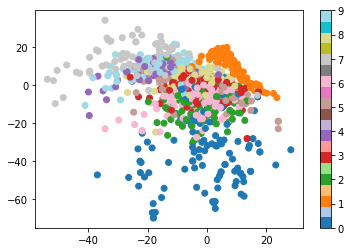

In [18]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [19]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [20]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

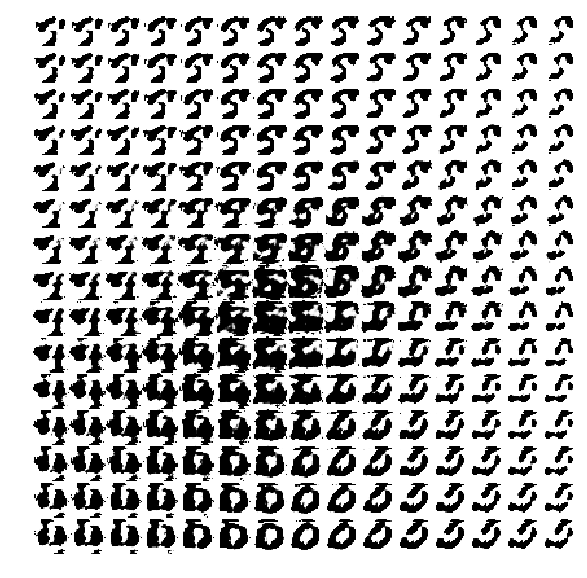

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

## <font color=#4267b2>VAE 互動</font>

In [22]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Blues')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Blues')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Blues')

In [23]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [34]:
import time
s = FloatSlider(value=0.1, min=0,max=1.0,step=0.05,)
step = widgets.IntSlider(value=5, min=1,max=20,step=1,description="step")
plot = widgets.interactive(inBetween, t=s)

In [35]:
pannel = [step,plot.children[0],plot.children[1]]
widgets.VBox(pannel)

In [37]:
## 執行以下區塊看中間圖形隨時間變化
for i in range(0,100,step.value):
    s.value = i/100
    time.sleep(1)

## <font color=#4267b2>成果 gif</font>